In [3]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib as plot

In [196]:
def convert_to_daily_returns(closing_prices):
    return closing_prices.pct_change()


def convert_to_total_returns(daily_rets):
    return (daily_rets + 1).cumprod() - 1


def calc_mu(daily_rets, center_mass):
    return daily_rets.ewm(com=center_mass).mean().iloc[-1]


def calc_cov(daily_rets, center_mass):
    return daily_rets.ewm(com=center_mass).cov().iloc[-5:]


def calc_markowitz_weights(mu_bar_vec, cov_mat, ret):
    A = np.ones((len(mu_bar_vec))) @ np.linalg.inv(cov_mat) @ mu_bar_vec.T
    B = mu_bar_vec @ np.linalg.inv(cov_mat) @ mu_bar_vec.T
    C = np.ones((len(mu_bar_vec))) @ np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T
    D = B*C - A**2
    
    return (B * np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T - A * np.linalg.inv(cov_mat) @ mu_bar_vec.T + 
ret * (C * np.linalg.inv(cov_mat) @ mu_bar_vec.T - A * np.linalg.inv(cov_mat) @ np.ones((len(mu_bar_vec))).T)) / D


def get_markowitz_weights(daily_rets, center_mass=60, target_ret=.1/252):
    mu = np.asarray(calc_mu(daily_rets, center_mass))
    cov = np.asarray(calc_cov(daily_rets, center_mass))
    return calc_markowitz_weights(mu, cov, target_ret)


def evaluate_markowitz_portfolio(daily_rets, start_date, end_date, center_mass=60, target_ret=.1/252):
    date_index = daily_rets.loc[start_date:end_date]
    portfolio_rets = pd.DataFrame(index=date_index.index,columns=['Return'])
    
    for date in date_index.index[:-1]:
        weights = get_markowitz_weights(daily_rets.loc[:date])
        idx = np.searchsorted(date_index.index, date)
        portfolio_rets.loc[date_index.index[idx+1], 'Return'] = weights @ np.asarray(daily_rets.loc[date_index.index[idx+1]]).T
        
    return portfolio_rets


def calc_sharpe(rets):
    return (rets.mean()[0] / rets.std()[0]) * np.sqrt(252)

def scale_to_vol(rets, target_vol=.1):
    return rets * (target_vol / rets.std())

In [13]:
PFE = pd.read_csv('PFE.csv', index_col='Date', parse_dates=True)
GE = pd.read_csv('GE.csv', index_col='Date', parse_dates=True)
JPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True)
XOM = pd.read_csv('XOM.csv', index_col='Date', parse_dates=True)
MSFT = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=True)

In [18]:
closing_prices = pd.DataFrame(index=PFE.index, columns=['PFE', 'GE', 'JPM', 'XOM', 'MSFT'])
closing_prices['PFE'] = PFE['Close']
closing_prices['GE'] = GE['Close']
closing_prices['JPM'] = JPM['Close']
closing_prices['XOM'] = XOM['Close']
closing_prices['MSFT'] = MSFT['Close']

In [58]:
daily_rets = convert_to_daily_returns(closing_prices)
total_returns = convert_to_total_returns(daily_rets)

In [192]:
markowitz_rets_2008 = evaluate_markowitz_portfolio(daily_rets, "2008", "2008-12-31")
markowitz_rets_2020 = evaluate_markowitz_portfolio(daily_rets, "2020", "2020-12-31")
markowitz_rets_1995 = evaluate_markowitz_portfolio(daily_rets, "1995", "1995-12-31")
markowitz_rets_full = evaluate_markowitz_portfolio(daily_rets, "1995", "2021-12-31")

In [193]:
markowitz_rets_2008 = scale_to_vol(markowitz_rets_2008)
markowitz_rets_2020 = scale_to_vol(markowitz_rets_2020)
markowitz_rets_1995 = scale_to_vol(markowitz_rets_1995)
markowitz_rets_full = scale_to_vol(markowitz_rets_full)

In [194]:
total_markowitz_rets_2008 = convert_to_total_returns(markowitz_rets_2008)
total_markowitz_rets_2020 = convert_to_total_returns(markowitz_rets_2020)
total_markowitz_rets_1995 = convert_to_total_returns(markowitz_rets_1995)
total_markowitz_rets_full = convert_to_total_returns(markowitz_rets_full)

2008 Sharpe:  -1.3545134004202903
2020 Sharpe:  1.1113584969577872
1995 Sharpe:  1.7383398561249004
1995-Present Sharpe:  0.41748230562598204


<AxesSubplot:xlabel='Date'>

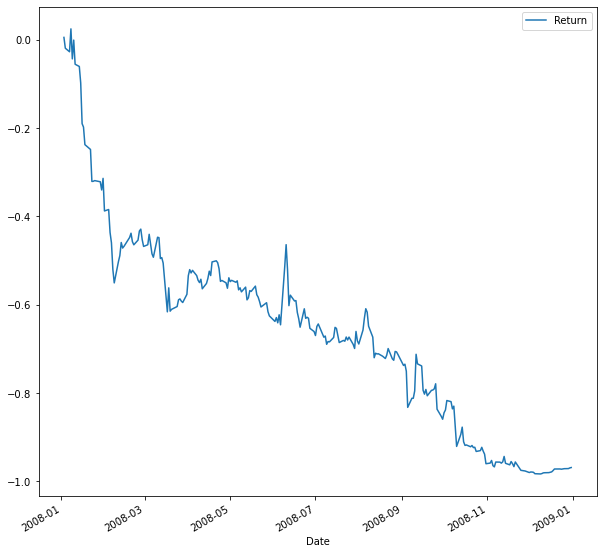

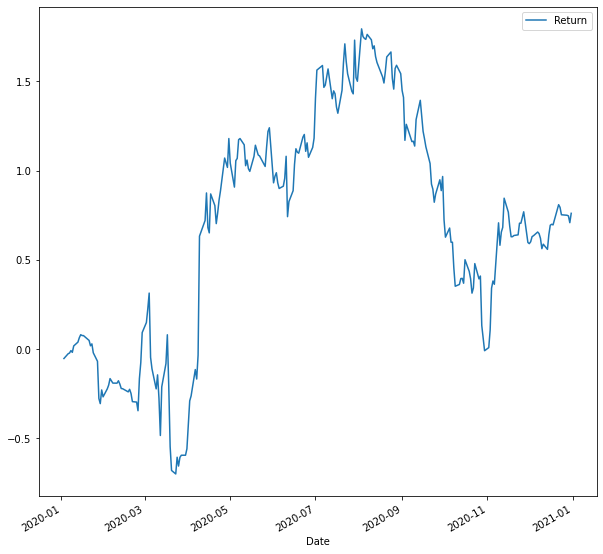

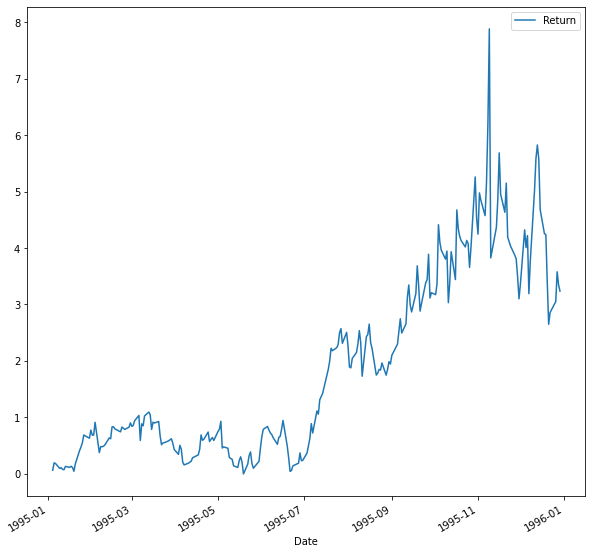

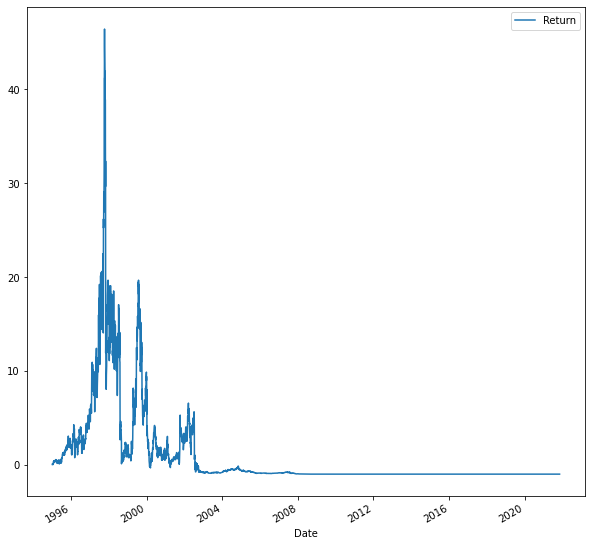

In [195]:
print("2008 Sharpe: " , calc_sharpe(markowitz_rets_2008))
total_markowitz_rets_2008.plot(figsize=(10,10))

print("2020 Sharpe: " , calc_sharpe(markowitz_rets_2020))
total_markowitz_rets_2020.plot(figsize=(10,10))

print("1995 Sharpe: " , calc_sharpe(markowitz_rets_1995))
total_markowitz_rets_1995.plot(figsize=(10,10))

print("1995-Present Sharpe: " , calc_sharpe(markowitz_rets_full))
total_markowitz_rets_full.plot(figsize=(10,10))

<AxesSubplot:xlabel='Date'>

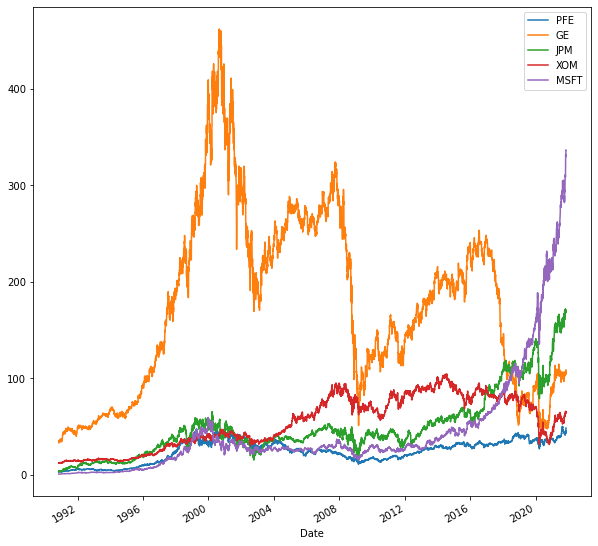

In [63]:
closing_prices.plot(figsize=(10,10))

<AxesSubplot:xlabel='Date'>

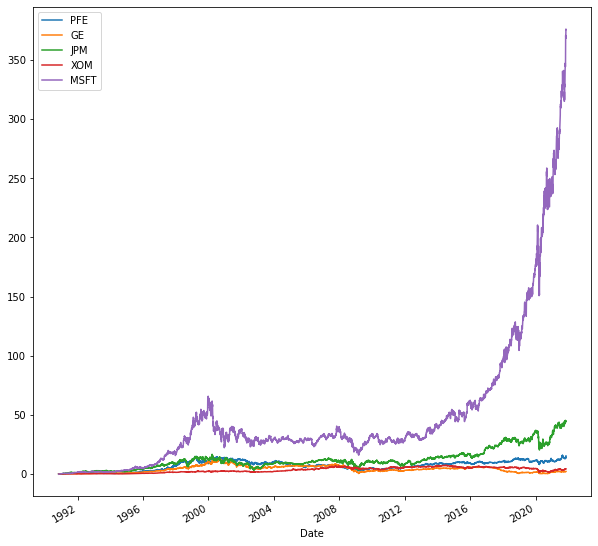

In [62]:
total_returns.plot(figsize=(10,10))